In [28]:
import tqdm
import numpy as np
import matplotlib.pyplot as plt
import imageio
import os

In [29]:
np.random.seed(42)

# 2 Dimensiones

In [30]:
def rosenbrock_2d(x):
    """
    Función de Rosenbrock en 2 dimensiones.
    Parámetros:
        x: array-like de tamaño 2 [x1, x2].
    Retorna:
        Valor de la función.
    """
    x1, x2 = x
    return 100 * (x2 - x1**2)**2 + (x1 - 1)**2

In [31]:
def rastrigin_2d(x):
    """
    Función de Rastrigin en 2 dimensiones.
    Parámetros:
        x: array-like de tamaño 2 [x1, x2].
    Retorna:
        Valor de la función.
    """
    x1, x2 = x
    return 10 * 2 + (x1**2 - 10 * np.cos(2 * np.pi * x1)) + (x2**2 - 10 * np.cos(2 * np.pi * x2))


In [32]:
def create_optimization_gif_2d(func, bounds, population_history, generations, gif_name="optimization_2d.gif"):
    x_bounds, y_bounds = bounds
    fig, ax = plt.subplots(figsize=(8, 6))

    # Crear malla para visualizar la función objetivo
    X = np.linspace(x_bounds[0], x_bounds[1], 200)
    Y = np.linspace(y_bounds[0], y_bounds[1], 200)
    X, Y = np.meshgrid(X, Y)
    Z = np.array([func([x, y]) for x, y in zip(np.ravel(X), np.ravel(Y))]).reshape(X.shape)

    # Dibujar el contorno inicial sin barra de color
    contour = ax.contourf(X, Y, Z, levels=50, cmap="viridis", alpha=0.7)

    frames = []  # Para almacenar los nombres de las imágenes temporales

    # Generar cuadros para cada generación
    for gen, population in enumerate(population_history):
        ax.clear()  # Limpiar el gráfico antes de cada cuadro
        ax.contourf(X, Y, Z, levels=50, cmap="viridis", alpha=0.7)  # Dibujar contorno

        # Dibujar los puntos de la población
        ax.scatter(
            population[:, 0],  # Coordenadas x
            population[:, 1],  # Coordenadas y
            c="red", s=20, label=f"Gen {gen + 1}/{generations}"
        )

        # Configurar límites y etiquetas
        ax.set_xlim(x_bounds)
        ax.set_ylim(y_bounds)
        ax.set_title(f"Optimización en 2D (Generación {gen + 1}/{generations})")
        ax.set_xlabel("X")
        ax.set_ylabel("Y")
        ax.legend(loc="upper right")

        # Guardar cuadro temporal
        frame_name = f"frame_{gen}.png"
        plt.savefig(frame_name)
        frames.append(frame_name)

    # Crear el GIF
    with imageio.get_writer(gif_name, mode='I', duration=0.5) as writer:
        for frame in frames:
            writer.append_data(imageio.imread(frame))

    # Eliminar cuadros temporales
    for frame in frames:
        os.remove(frame)

    print(f"GIF guardado como: {gif_name}")

In [33]:
def visualize_optimization(func, bounds, best_values, all_populations):
    # Configurar el espacio de búsqueda
    x = np.linspace(bounds[0][0], bounds[0][1], 500)
    y = np.linspace(bounds[1][0], bounds[1][1], 500)
    X, Y = np.meshgrid(x, y)
    Z = np.array([func([x, y]) for x, y in zip(np.ravel(X), np.ravel(Y))]).reshape(X.shape)

    # Gráfico de la evolución de la población
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))

    # Gráfico 1: Progreso del mejor valor
    ax[0].plot(best_values, label="Mejor valor", color='blue')
    ax[0].set_title("Progreso del mejor valor")
    ax[0].set_xlabel("Generaciones")
    ax[0].set_ylabel("Valor de la función objetivo")
    ax[0].legend()

    # Gráfico 2: Distribución de la población
    ax[1].contourf(X, Y, Z, levels=50, cmap="viridis")
    ax[1].set_title("Evolución de la población en el espacio de búsqueda")
    ax[1].set_xlabel("X1")
    ax[1].set_ylabel("X2")

    # Agregar las poblaciones
    for i, population in enumerate(all_populations):
        if i % (len(all_populations) // 10) == 0:  # Mostrar solo algunas generaciones
            ax[1].scatter(population[:, 0], population[:, 1], label=f"Gen {i+1}", alpha=0.6)
    
    ax[1].legend(loc="upper right", fontsize=8)
    plt.tight_layout()
    plt.show()


## Algoritmos Evolutivos

In [34]:
def evolutionary_algorithm(func, bounds, population_size, generations, mutation_rate):
    # Inicialización
    dim = len(bounds)
    population = np.random.uniform(
        [b[0] for b in bounds], [b[1] for b in bounds], size=(population_size, dim)
    )
    best_values = []  # Almacena el mejor valor por generación
    all_populations = []  # Almacena la población de cada generación

    for generation in tqdm.tqdm(range(generations), desc="Generations"):
        # Evaluar la población
        scores = np.array([func(individual) for individual in population])
        
        # Guardar el mejor valor y la población actual
        best_values.append(np.min(scores))
        all_populations.append(population.copy())
        
        # Selección: mantener los mejores
        sorted_indices = np.argsort(scores)
        population = population[sorted_indices[:population_size // 2]]
        
        # Cruce: generar nueva descendencia
        offspring = []
        while len(offspring) < population_size:
            parents = population[np.random.choice(population_size // 2, 2, replace=False)]
            child = (parents[0] + parents[1]) / 2
            offspring.append(child)
        
        # Mutación
        for i in range(len(offspring)):
            if np.random.random() < mutation_rate:
                offspring[i] += np.random.uniform(-0.1, 0.1, size=dim)
        
        # Actualizar la población
        population = np.array(offspring)

    # Devolver resultados y datos para visualización
    best_solution = population[np.argmin([func(ind) for ind in population])]
    return best_solution, func(best_solution), best_values, all_populations


## Optimización Enjambre de Partículas

In [35]:
def pso(func, bounds, num_particles, generations, inertia, cognitive, social):
    # Inicialización
    dim = len(bounds)
    particles = np.random.uniform(
        [b[0] for b in bounds], [b[1] for b in bounds], size=(num_particles, dim)
    )
    velocities = np.random.uniform(-1, 1, size=(num_particles, dim))
    personal_best_positions = particles.copy()
    personal_best_scores = np.array([func(p) for p in particles])
    global_best_position = personal_best_positions[np.argmin(personal_best_scores)]
    global_best_score = func(global_best_position)

    # Almacenar datos para visualización
    best_values = []
    all_positions = []

    # Iteraciones
    for generation in tqdm.tqdm(range(generations), desc="Generations"):
        # Evaluar partículas
        scores = np.array([func(p) for p in particles])
        all_positions.append(particles.copy())
        best_values.append(global_best_score)

        # Actualizar los mejores personales y global
        for i in range(num_particles):
            if scores[i] < personal_best_scores[i]:
                personal_best_scores[i] = scores[i]
                personal_best_positions[i] = particles[i]
        if np.min(scores) < global_best_score:
            global_best_score = np.min(scores)
            global_best_position = particles[np.argmin(scores)]

        # Actualizar velocidades y posiciones
        r1, r2 = np.random.random(dim), np.random.random(dim)
        for i in range(num_particles):
            velocities[i] = (
                inertia * velocities[i]
                + cognitive * r1 * (personal_best_positions[i] - particles[i])
                + social * r2 * (global_best_position - particles[i])
            )
            particles[i] += velocities[i]
            # Restringir partículas dentro de los límites
            particles[i] = np.clip(particles[i], [b[0] for b in bounds], [b[1] for b in bounds])

    return global_best_position, global_best_score, best_values, all_positions


In [36]:
def visualize_pso(func, bounds, best_values, all_positions):
    # Configurar el espacio de búsqueda
    x = np.linspace(bounds[0][0], bounds[0][1], 500)
    y = np.linspace(bounds[1][0], bounds[1][1], 500)
    X, Y = np.meshgrid(x, y)
    Z = np.array([func([x, y]) for x, y in zip(np.ravel(X), np.ravel(Y))]).reshape(X.shape)

    # Gráfico de la evolución de las partículas
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))

    # Gráfico 1: Progreso del mejor valor
    ax[0].plot(best_values, label="Mejor valor", color='blue')
    ax[0].set_title("Progreso del mejor valor")
    ax[0].set_xlabel("Generaciones")
    ax[0].set_ylabel("Valor de la función objetivo")
    ax[0].legend()

    # Gráfico 2: Distribución de las partículas
    ax[1].contourf(X, Y, Z, levels=50, cmap="viridis")
    ax[1].set_title("Evolución de las partículas en el espacio de búsqueda")
    ax[1].set_xlabel("X1")
    ax[1].set_ylabel("X2")

    # Agregar las posiciones de las partículas
    for i, positions in enumerate(all_positions):
        if i % (len(all_positions) // 10) == 0:  # Mostrar algunas generaciones
            ax[1].scatter(positions[:, 0], positions[:, 1], label=f"Gen {i+1}", alpha=0.6)
    
    ax[1].legend(loc="upper right", fontsize=8)
    plt.tight_layout()
    plt.show()


## Evolución Diferencial

In [37]:
def differential_evolution(func, bounds, population_size, generations, F, CR):
    dim = len(bounds)
    population = np.random.uniform(
        [b[0] for b in bounds], [b[1] for b in bounds], size=(population_size, dim)
    )
    scores = np.array([func(ind) for ind in population])
    
    best_values = []
    population_history = [population.copy()]  # Rastreo de las poblaciones

    for generation in tqdm.tqdm(range(generations), desc="Generations"):
        new_population = []
        for i in range(population_size):
            r1, r2, r3 = np.random.choice(
                [j for j in range(population_size) if j != i], 3, replace=False
            )
            mutant = population[r1] + F * (population[r2] - population[r3])
            mutant = np.clip(mutant, [b[0] for b in bounds], [b[1] for b in bounds])
            
            trial = np.where(
                np.random.rand(dim) < CR, mutant, population[i]
            )
            trial_score = func(trial)
            if trial_score < scores[i]:
                new_population.append(trial)
                scores[i] = trial_score
            else:
                new_population.append(population[i])
        
        population = np.array(new_population)
        population_history.append(population.copy())  # Guardar la nueva población
        best_values.append(np.min(scores))
    
    best_index = np.argmin(scores)
    return population[best_index], scores[best_index], best_values, population_history


In [38]:
def visualize_differential_evolution(func, bounds, population_history, best_values):
    x = np.linspace(bounds[0][0], bounds[0][1], 500)
    y = np.linspace(bounds[1][0], bounds[1][1], 500)
    X, Y = np.meshgrid(x, y)
    Z = np.array([[func([x_, y_]) for x_ in x] for y_ in y])

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))
    levels = np.logspace(0, 5, 35, base=2.0)
    contour = ax1.contour(X, Y, Z, levels=levels, cmap='viridis', alpha=0.7)
    ax1.set_title("Optimización con Evolución Diferencial")
    ax1.set_xlabel("x")
    ax1.set_ylabel("y")

    # Mostrar la última población
    ax1.scatter(population_history[-1][:, 0], population_history[-1][:, 1], color='red', label="Población final")
    ax1.legend()

    # Graficar la evolución de la función de coste
    ax2.plot(range(len(best_values)), best_values, color='blue')
    ax2.set_title("Evolución de la Función de Coste")
    ax2.set_xlabel("Generación")
    ax2.set_ylabel("Coste")

    plt.show()

## Rosenbrock

### Algoritmos Evolutivos

Generations: 100%|██████████| 300/300 [00:00<00:00, 1965.81it/s]


Mejor solución encontrada: [0.90536848 0.82231008]
Valor de la función objetivo: 0.009640511019589649


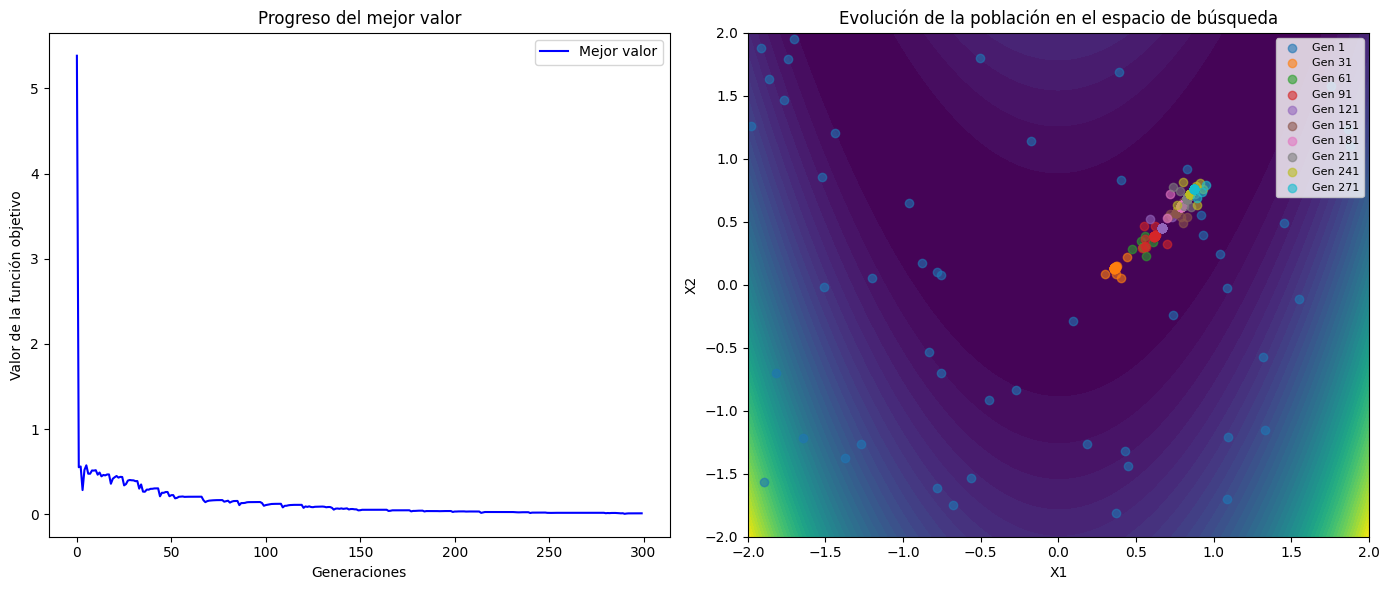

In [39]:
best_solution, best_score, best_values, population_history = evolutionary_algorithm(
    rosenbrock_2d, 
    bounds=[(-2, 2), (-2, 2)],
    population_size=50,
    generations=300,
    mutation_rate=0.1
)

print("Mejor solución encontrada:", best_solution)
print("Valor de la función objetivo:", best_score)

visualize_optimization(
    func=rosenbrock_2d, 
    bounds=[(-2, 2), (-2, 2)], 
    best_values=best_values, 
    all_populations=population_history
)

C:\Users\alexg\AppData\Local\Temp\ipykernel_26504\3885850942.py:44: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  writer.append_data(imageio.imread(frame))


GIF guardado como: rosenbrock_evolutionary_algorithm_2d.gif


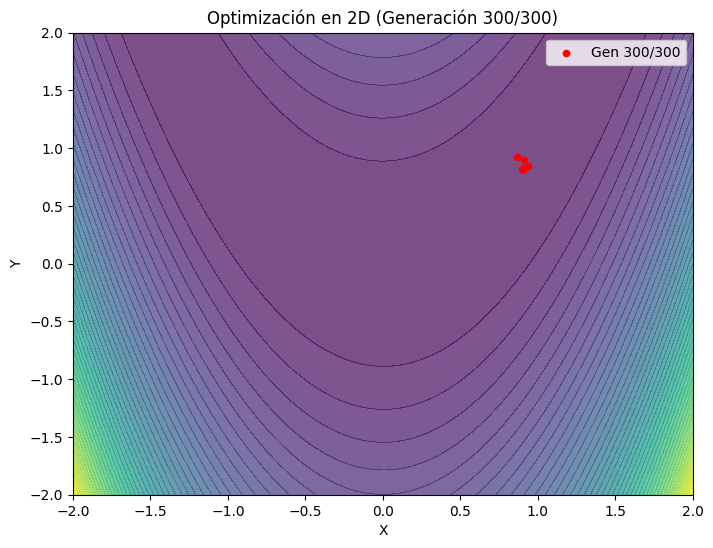

In [40]:
create_optimization_gif_2d(
    func=rosenbrock_2d,
    bounds=[(-2, 2), (-2, 2)],
    population_history=population_history,
    generations=300,
    gif_name="rosenbrock_evolutionary_algorithm_2d.gif"
)

### Optimización Enjambre de Partículas

Generations:   0%|          | 0/300 [00:00<?, ?it/s]

Generations: 100%|██████████| 300/300 [00:00<00:00, 2421.92it/s]


Mejor posición encontrada: [1.00000573 0.99998706]
Valor de la función objetivo: 2.9200290555617844e-11


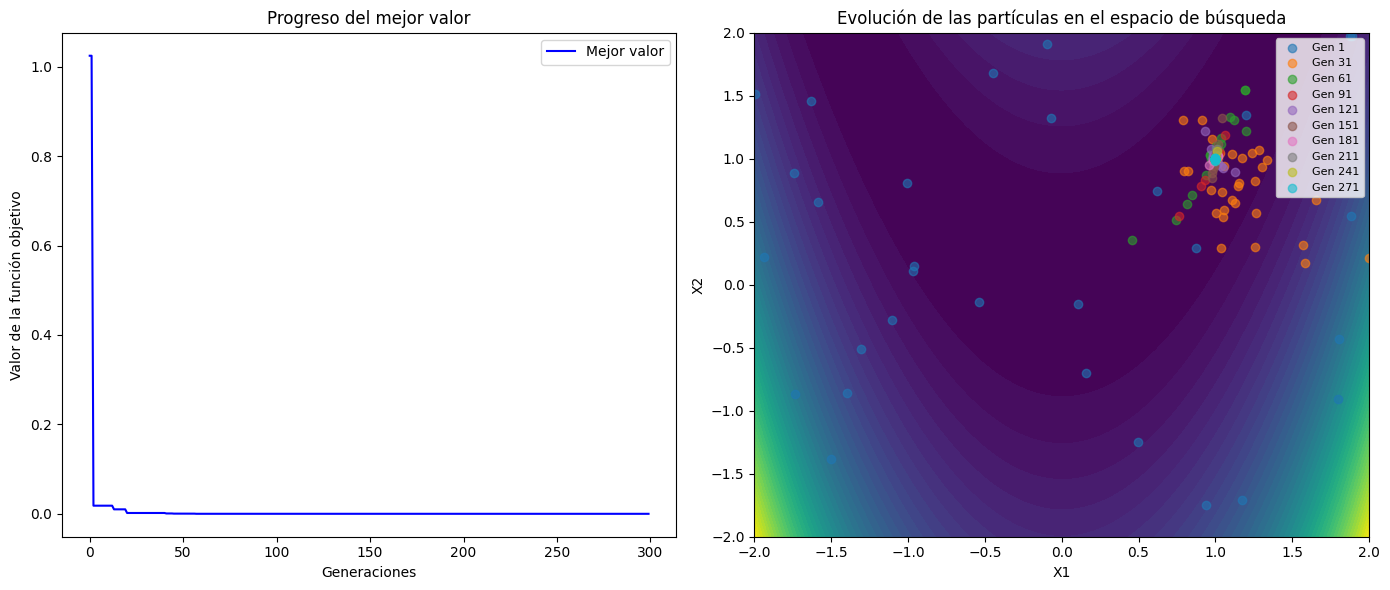

In [41]:
# Parámetros de PSO
bounds = [(-2, 2), (-2, 2)]
num_particles = 30
generations = 300
inertia = 0.7
cognitive = 1.5
social = 1.5


# Ejecutar el algoritmo
best_position, best_score, best_values, all_positions = pso(
    rosenbrock_2d, bounds, num_particles, generations, inertia, cognitive, social
)

print("Mejor posición encontrada:", best_position)
print("Valor de la función objetivo:", best_score)

visualize_pso(rosenbrock_2d, bounds, best_values, all_positions)

C:\Users\alexg\AppData\Local\Temp\ipykernel_26504\3885850942.py:44: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  writer.append_data(imageio.imread(frame))


GIF guardado como: rosenbrock_pso_2d.gif


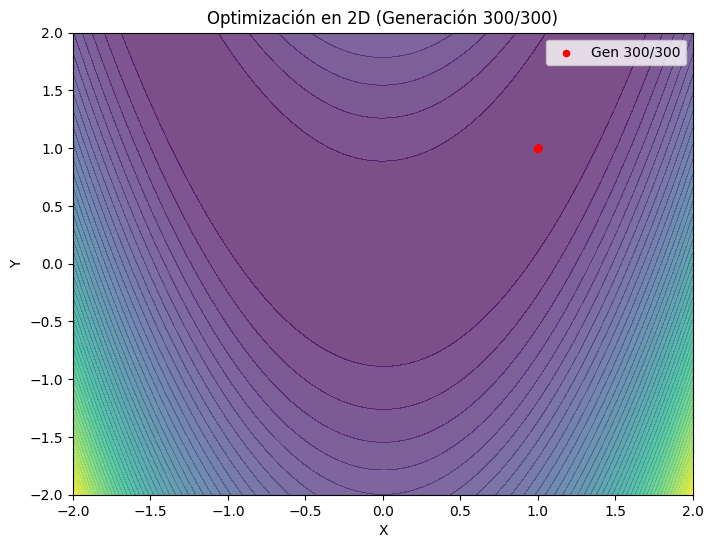

In [42]:
create_optimization_gif_2d(
    func=rosenbrock_2d,
    bounds=[(-2, 2), (-2, 2)],
    population_history=all_positions,
    generations=300,
    gif_name="rosenbrock_pso_2d.gif"
)

### Evolución Diferencial

Generations: 100%|██████████| 300/300 [00:00<00:00, 762.97it/s]


Mejor posición encontrada: [1. 1.]
Valor de la función objetivo: 0.0


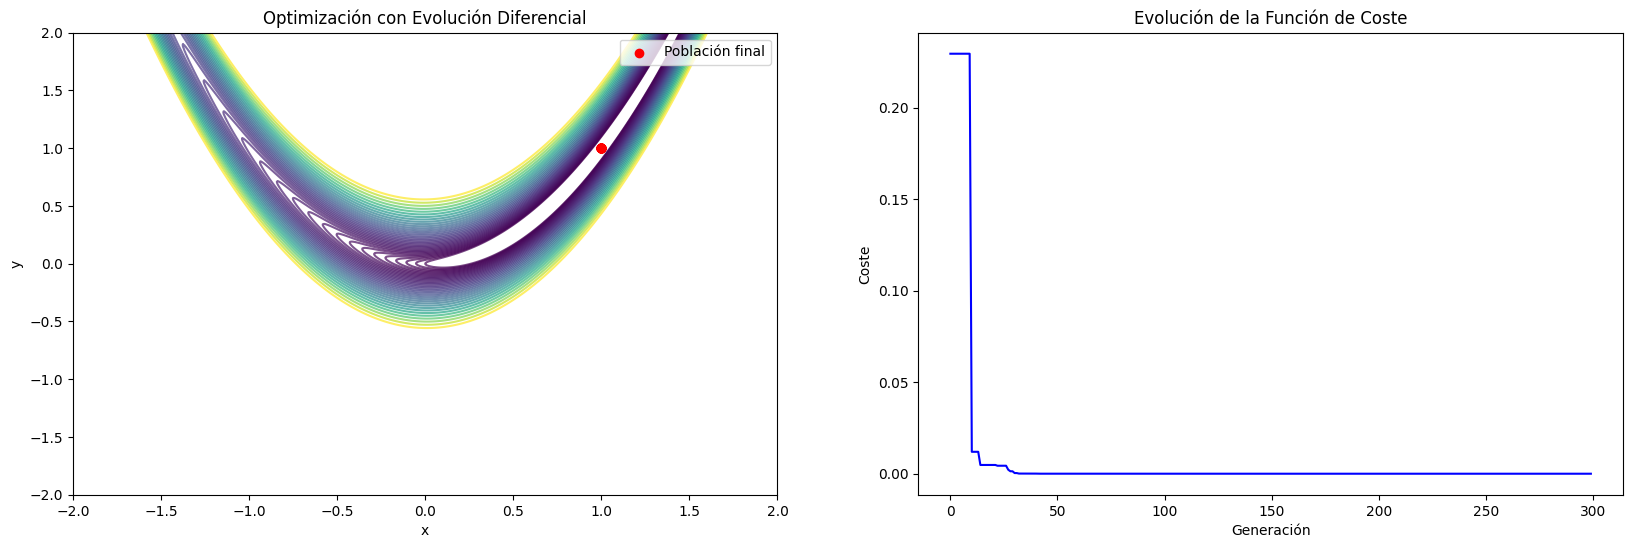

In [43]:
best_position, best_score, best_values, population_history = differential_evolution(
    func=rosenbrock_2d,  # Función objetivo
    bounds=[(-2, 2), (-2, 2)],  # Límites del espacio
    population_size=50,  # Tamaño de la población
    generations=300,  # Número de generaciones
    F=0.8,  # Factor de escala
    CR=0.9,  # Tasa de recombinación
)
print("Mejor posición encontrada:", best_position)
print("Valor de la función objetivo:", best_score)

visualize_differential_evolution(
    func=rosenbrock_2d,
    bounds=[(-2, 2), (-2, 2)],
    population_history=population_history,
    best_values=best_values
)

In [44]:
best_values

[np.float64(0.22951457282606363),
 np.float64(0.22951457282606363),
 np.float64(0.22951457282606363),
 np.float64(0.22951457282606363),
 np.float64(0.22951457282606363),
 np.float64(0.22951457282606363),
 np.float64(0.22951457282606363),
 np.float64(0.22951457282606363),
 np.float64(0.22951457282606363),
 np.float64(0.22951457282606363),
 np.float64(0.011980737841329582),
 np.float64(0.011980737841329582),
 np.float64(0.011980737841329582),
 np.float64(0.011980737841329582),
 np.float64(0.004785482193073242),
 np.float64(0.004785482193073242),
 np.float64(0.004785482193073242),
 np.float64(0.004785482193073242),
 np.float64(0.004785482193073242),
 np.float64(0.004785482193073242),
 np.float64(0.004785482193073242),
 np.float64(0.004785482193073242),
 np.float64(0.004365611450679092),
 np.float64(0.004365611450679092),
 np.float64(0.004365611450679092),
 np.float64(0.004365611450679092),
 np.float64(0.004365611450679092),
 np.float64(0.002202437843174367),
 np.float64(0.0013379420735846

C:\Users\alexg\AppData\Local\Temp\ipykernel_26504\3885850942.py:44: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  writer.append_data(imageio.imread(frame))


GIF guardado como: rosenbrock_differential_evolution_2d.gif


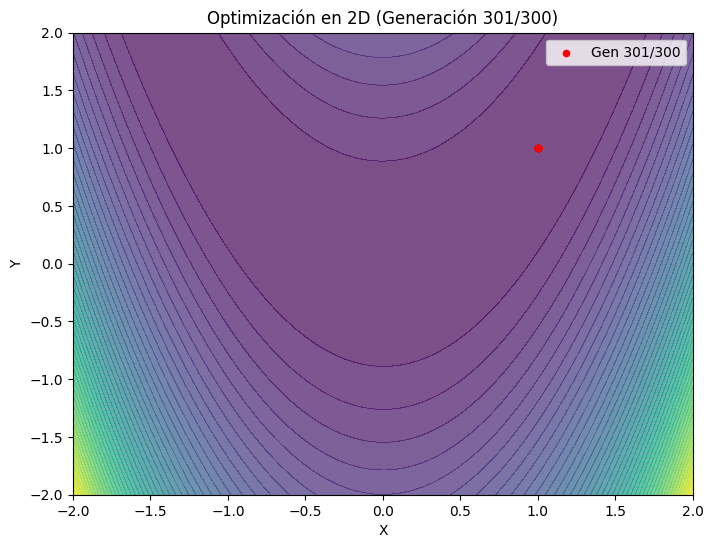

In [45]:
create_optimization_gif_2d(
    func=rosenbrock_2d,
    bounds=[(-2, 2), (-2, 2)],
    population_history=population_history,
    generations=300,
    gif_name="rosenbrock_differential_evolution_2d.gif"
)

## Rastrigin

### Algoritmos Evolutivos

Generations: 100%|██████████| 300/300 [00:00<00:00, 1574.59it/s]


Mejor solución encontrada: [-8.46562149e-09 -1.01972322e-09]
Valor de la función objetivo: 1.4210854715202004e-14


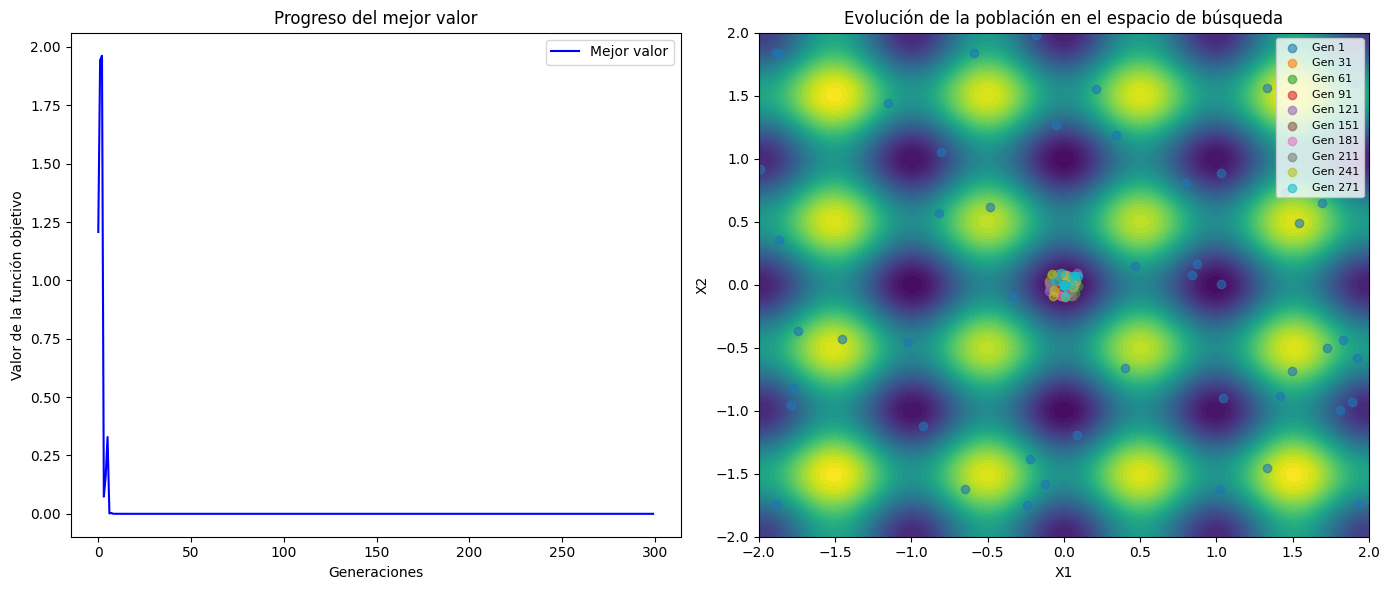

In [46]:
best_solution, best_score, best_values, population_history = evolutionary_algorithm(
    rastrigin_2d, 
    bounds=[(-2, 2), (-2, 2)],
    population_size=50,
    generations=300,
    mutation_rate=0.1
)

print("Mejor solución encontrada:", best_solution)
print("Valor de la función objetivo:", best_score)

visualize_optimization(
    func=rastrigin_2d, 
    bounds=[(-2, 2), (-2, 2)], 
    best_values=best_values, 
    all_populations=population_history
)

C:\Users\alexg\AppData\Local\Temp\ipykernel_26504\3885850942.py:44: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  writer.append_data(imageio.imread(frame))


GIF guardado como: rastrigin_evolutionary_algorithm_2d.gif


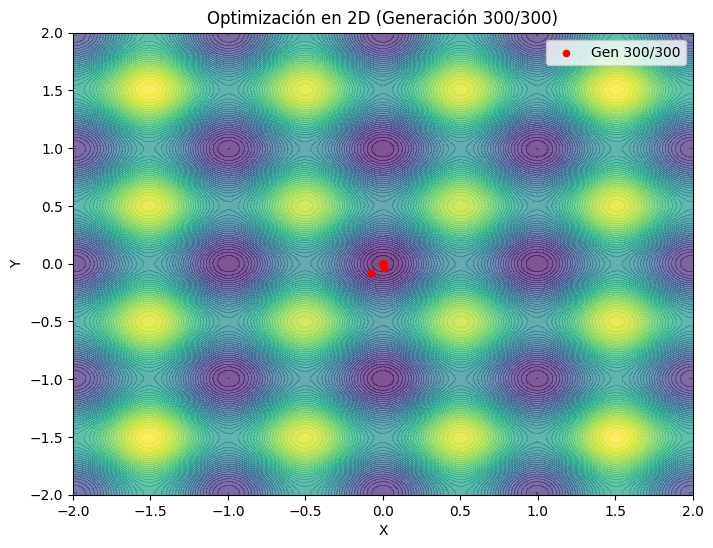

In [47]:
create_optimization_gif_2d(
    func=rastrigin_2d,
    bounds=[(-2, 2), (-2, 2)],
    population_history=population_history,
    generations=300,
    gif_name="rastrigin_evolutionary_algorithm_2d.gif"
)

### Optimización Enjambre de Partículas

Generations: 100%|██████████| 300/300 [00:00<00:00, 2923.85it/s]


Mejor posición encontrada: [-5.91032854e-10 -1.48878875e-09]
Valor de la función objetivo: 0.0


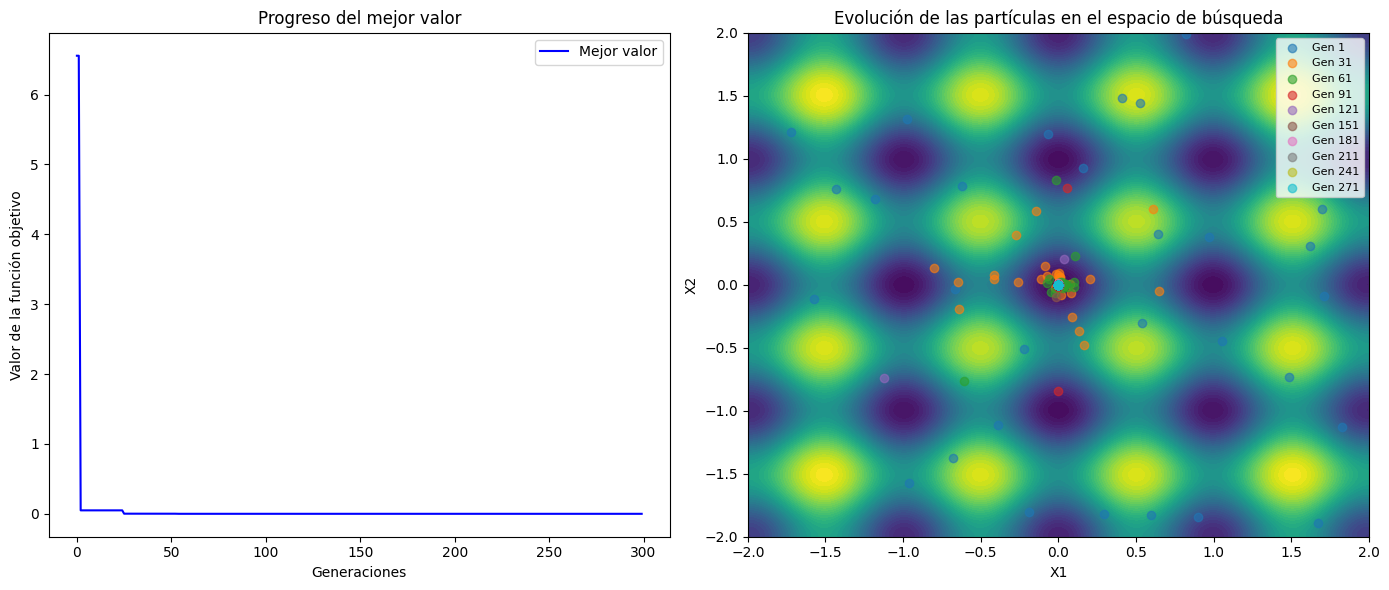

In [48]:
# Parámetros de PSO
bounds = [(-2, 2), (-2, 2)]
num_particles = 30
generations = 300
inertia = 0.7
cognitive = 1.5
social = 1.5


# Ejecutar el algoritmo
best_position, best_score, best_values, all_positions = pso(
    rastrigin_2d, bounds, num_particles, generations, inertia, cognitive, social
)

print("Mejor posición encontrada:", best_position)
print("Valor de la función objetivo:", best_score)

visualize_pso(rastrigin_2d, bounds, best_values, all_positions)

C:\Users\alexg\AppData\Local\Temp\ipykernel_26504\3885850942.py:44: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  writer.append_data(imageio.imread(frame))


GIF guardado como: rastrigin_pso_2d.gif


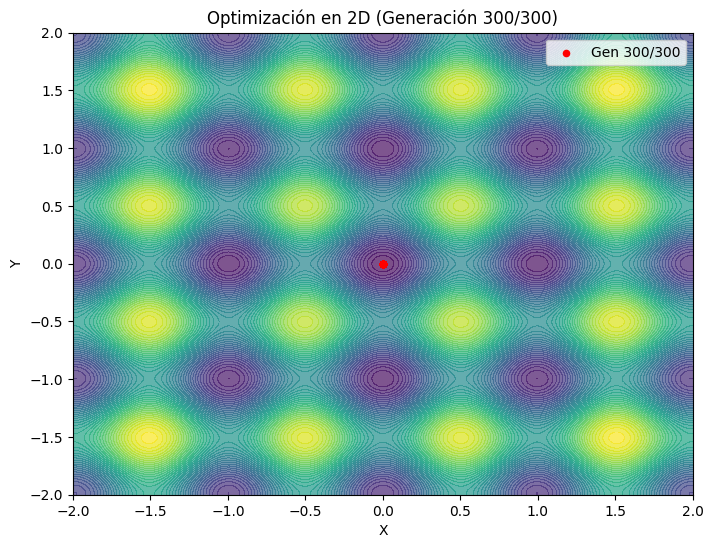

In [49]:
create_optimization_gif_2d(
    func=rastrigin_2d,
    bounds=[(-2, 2), (-2, 2)],
    population_history=all_positions,
    generations=300,
    gif_name="rastrigin_pso_2d.gif"
)

### Evolución Diferencial

Generations: 100%|██████████| 300/300 [00:00<00:00, 748.27it/s]


Mejor posición encontrada: [5.24875118e-10 6.14868749e-10]
Valor de la función objetivo: 0.0


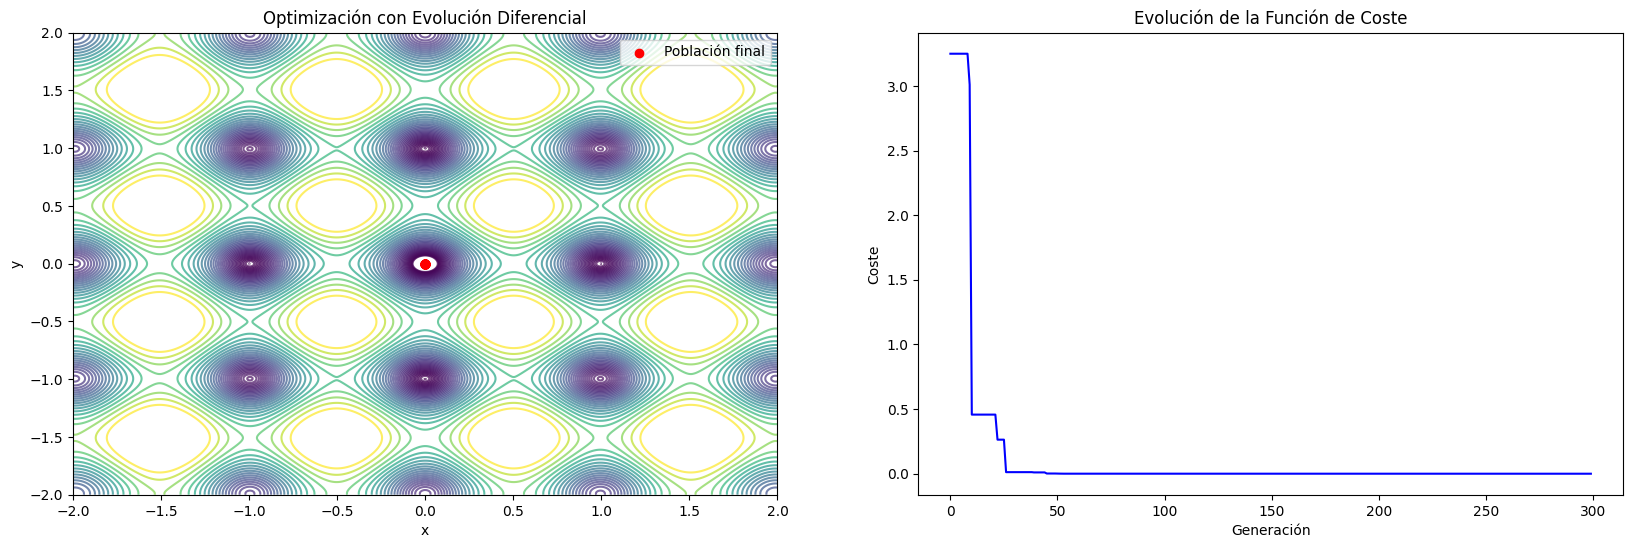

In [50]:
best_position, best_score, best_values, population_history = differential_evolution(
    func=rastrigin_2d,  # Función objetivo
    bounds=[(-2, 2), (-2, 2)],  # Límites del espacio
    population_size=50,  # Tamaño de la población
    generations=300,  # Número de generaciones
    F=0.8,  # Factor de escala
    CR=0.9,  # Tasa de recombinación
)
print("Mejor posición encontrada:", best_position)
print("Valor de la función objetivo:", best_score)

visualize_differential_evolution(
    func=rastrigin_2d,
    bounds=[(-2, 2), (-2, 2)],
    population_history=population_history,
    best_values=best_values
)

C:\Users\alexg\AppData\Local\Temp\ipykernel_26504\3885850942.py:44: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  writer.append_data(imageio.imread(frame))


GIF guardado como: rastrigin_differential_evolution_2d.gif


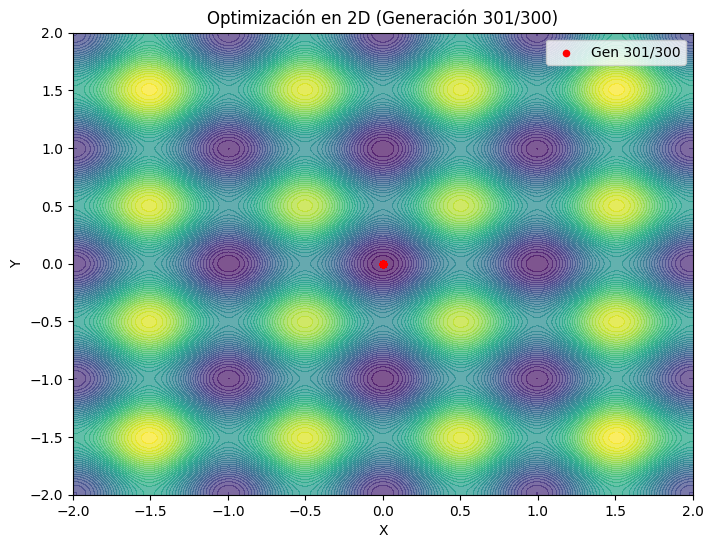

In [51]:
create_optimization_gif_2d(
    func=rastrigin_2d,
    bounds=[(-2, 2), (-2, 2)],
    population_history=population_history,
    generations=300,
    gif_name="rastrigin_differential_evolution_2d.gif"
)

# 3 Dimensiones

In [52]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation

In [53]:
def rosenbrock_3d(x):
    """
    Función de Rosenbrock en 3 dimensiones.
    Parámetros:
        x: array-like de tamaño 3 [x1, x2, x3].
    Retorna:
        Valor de la función.
    """
    x1, x2, x3 = x
    return (
        100 * (x2 - x1**2)**2 + (x1 - 1)**2 +
        100 * (x3 - x2**2)**2 + (x2 - 1)**2
    )


In [54]:
def rastrigin_3d(x):
    """
    Función de Rastrigin en 3 dimensiones.
    Parámetros:
        x: array-like de tamaño 3 [x1, x2, x3].
    Retorna:
        Valor de la función.
    """
    x1, x2, x3 = x
    return (
        10 * 3 +
        (x1**2 - 10 * np.cos(2 * np.pi * x1)) +
        (x2**2 - 10 * np.cos(2 * np.pi * x2)) +
        (x3**2 - 10 * np.cos(2 * np.pi * x3))
    )

In [55]:
def visualize_population_3d(func, bounds, population_history, generations):
    x_bounds, y_bounds, z_bounds = bounds
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection="3d")

    # Crear malla para visualizar la función objetivo
    X = np.linspace(x_bounds[0], x_bounds[1], 100)
    Y = np.linspace(y_bounds[0], y_bounds[1], 100)
    Z = np.linspace(z_bounds[0], z_bounds[1], 100)

    X, Y = np.meshgrid(X, Y)
    Z = np.array([func([x, y, 0]) for x, y in zip(np.ravel(X), np.ravel(Y))]).reshape(X.shape)

    ax.plot_surface(X, Y, Z, cmap="viridis", alpha=0.6)

    # Animación de las generaciones
    for gen, population in enumerate(population_history):
        ax.scatter(
            population[:, 0],  # Coordenadas x
            population[:, 1],  # Coordenadas y
            np.array([func(ind) for ind in population]),  # Coordenadas z
            c="red", s=20, label=f"Gen {gen}" if gen == 0 else None
        )

    # Configuración de límites dinámicos
    ax.set_xlim(x_bounds)
    ax.set_ylim(y_bounds)
    ax.set_zlim([Z.min(), Z.max()])  # Usar los valores de Z calculados
    ax.set_title(f"Optimización en 3D ({generations} generaciones)")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    plt.show()

In [56]:
def create_optimization_gif_3d(func, bounds, population_history, generations, gif_name="optimization.gif"):
    x_bounds, y_bounds, z_bounds = bounds
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection="3d")

    # Crear malla para visualizar la función objetivo
    X = np.linspace(x_bounds[0], x_bounds[1], 100)
    Y = np.linspace(y_bounds[0], y_bounds[1], 100)
    Z = np.linspace(z_bounds[0], z_bounds[1], 100)

    X, Y = np.meshgrid(X, Y)
    Z = np.array([func([x, y, 0]) for x, y in zip(np.ravel(X), np.ravel(Y))]).reshape(X.shape)

    ax.plot_surface(X, Y, Z, cmap="viridis", alpha=0.6)

    frames = []  # Para almacenar los nombres de las imágenes temporales

    # Generar cuadros para cada generación
    for gen, population in enumerate(population_history):
        ax.clear()
        ax.plot_surface(X, Y, Z, cmap="viridis", alpha=0.6)

        ax.scatter(
            population[:, 0],  # Coordenadas x
            population[:, 1],  # Coordenadas y
            np.array([func(ind) for ind in population]),  # Coordenadas z
            c="red", s=20, label=f"Gen {gen}"
        )
        ax.set_xlim(x_bounds)
        ax.set_ylim(y_bounds)
        ax.set_zlim([Z.min(), Z.max()])
        ax.set_title(f"Optimización en 3D (Generación {gen + 1}/{generations})")
        ax.set_xlabel("X")
        ax.set_ylabel("Y")
        ax.set_zlabel("Z")

        # Guardar cuadro temporal
        frame_name = f"frame_{gen}.png"
        plt.savefig(frame_name)
        frames.append(frame_name)

    # Crear el GIF
    with imageio.get_writer(gif_name, mode='I', duration=0.5) as writer:
        for frame in frames:
            writer.append_data(imageio.imread(frame))

    # Eliminar cuadros temporales
    for frame in frames:
        os.remove(frame)

    print(f"GIF guardado como: {gif_name}")


## Algoritmos Evolutivos

In [57]:
def evolutionary_algorithm_3d(func, bounds, population_size, generations, mutation_rate, crossover_rate):
    dim = len(bounds)
    population = np.random.uniform(
        [b[0] for b in bounds], [b[1] for b in bounds], size=(population_size, dim)
    )
    scores = np.array([func(ind) for ind in population])
    best_values = []
    population_history = [population.copy()]  # Seguimiento de poblaciones

    for gen in range(generations):
        new_population = []
        for i in range(population_size):
            if np.random.rand() < mutation_rate:
                individual = population[i] + np.random.uniform(-1, 1, dim)
                individual = np.clip(individual, [b[0] for b in bounds], [b[1] for b in bounds])
            else:
                parents = population[np.random.choice(population_size, 2, replace=False)]
                individual = np.where(np.random.rand(dim) < crossover_rate, parents[0], parents[1])
            
            trial_score = func(individual)
            if trial_score < scores[i]:
                new_population.append(individual)
                scores[i] = trial_score
            else:
                new_population.append(population[i])
        
        population = np.array(new_population)
        population_history.append(population.copy())  # Guardar la población
        best_values.append(np.min(scores))
    
    best_index = np.argmin(scores)
    return population[best_index], scores[best_index], best_values, population_history


## Optimización Enjambre de Partículas

In [58]:
def particle_swarm_optimization_3d(func, bounds, num_particles, generations, w, c1, c2):
    dim = len(bounds)
    particles = np.random.uniform(
        [b[0] for b in bounds], [b[1] for b in bounds], size=(num_particles, dim)
    )
    velocities = np.random.uniform(-1, 1, (num_particles, dim))
    personal_best_positions = particles.copy()
    personal_best_scores = np.array([func(ind) for ind in particles])
    global_best_position = personal_best_positions[np.argmin(personal_best_scores)]
    global_best_score = np.min(personal_best_scores)

    best_values = []
    particle_history = [particles.copy()]  # Seguimiento de partículas

    for gen in range(generations):
        for i in range(num_particles):
            r1, r2 = np.random.rand(dim), np.random.rand(dim)
            velocities[i] = (
                w * velocities[i]
                + c1 * r1 * (personal_best_positions[i] - particles[i])
                + c2 * r2 * (global_best_position - particles[i])
            )
            particles[i] = np.clip(
                particles[i] + velocities[i], [b[0] for b in bounds], [b[1] for b in bounds]
            )
            score = func(particles[i])
            if score < personal_best_scores[i]:
                personal_best_scores[i] = score
                personal_best_positions[i] = particles[i]
                if score < global_best_score:
                    global_best_score = score
                    global_best_position = particles[i]
        
        particle_history.append(particles.copy())  # Guardar el progreso
        best_values.append(global_best_score)

    return global_best_position, global_best_score, best_values, particle_history


## Evolución Diferencial

In [59]:
def differential_evolution_3d(func, bounds, population_size, generations, mutation_factor, crossover_probability):
    dim = len(bounds)
    population = np.random.uniform(
        [b[0] for b in bounds], [b[1] for b in bounds], size=(population_size, dim)
    )
    scores = np.array([func(ind) for ind in population])
    best_values = []
    population_history = [population.copy()]  # Seguimiento de poblaciones

    for gen in range(generations):
        new_population = population.copy()
        for i in range(population_size):
            # Seleccionar 3 individuos diferentes
            indices = np.random.choice(np.delete(np.arange(population_size), i), 3, replace=False)
            a, b, c = population[indices]

            # Generar vector mutante
            mutant = a + mutation_factor * (b - c)
            mutant = np.clip(mutant, [b[0] for b in bounds], [b[1] for b in bounds])

            # Recombinación
            trial = np.array([
                mutant[j] if np.random.rand() < crossover_probability else population[i, j]
                for j in range(dim)
            ])

            # Selección: comparar el individuo actual con el vector de prueba
            trial_score = func(trial)
            if trial_score < scores[i]:
                new_population[i] = trial
                scores[i] = trial_score

        population = new_population
        population_history.append(population.copy())  # Guardar la población
        best_values.append(np.min(scores))

    best_index = np.argmin(scores)
    return population[best_index], scores[best_index], best_values, population_history

## Rosenbrock

### Algoritmos Evolutivos

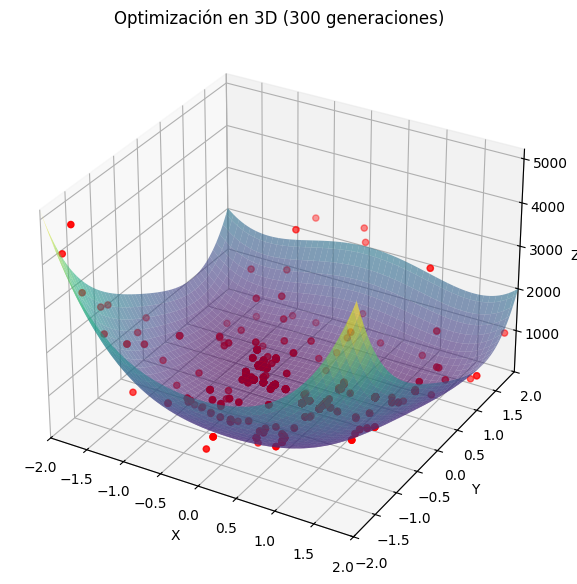

Mejor posición encontrada: [0.82886984 0.65827447 0.39724665]
Valor de la función objetivo: 0.35888916598554577


In [60]:
best_position, best_score, best_values, population_history = evolutionary_algorithm_3d(
    func=rosenbrock_3d,
    bounds=[(-2, 2), (-2, 2), (-2, 2)],
    population_size=50,
    generations=300,
    mutation_rate=0.2,
    crossover_rate=0.5,
)

visualize_population_3d(
    func=rosenbrock_3d,
    bounds=[(-2, 2), (-2, 2), (-2, 2)],
    population_history=population_history,
    generations=300,
)

print("Mejor posición encontrada:", best_position)
print("Valor de la función objetivo:", best_score)

C:\Users\alexg\AppData\Local\Temp\ipykernel_26504\1495813386.py:45: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  writer.append_data(imageio.imread(frame))


GIF guardado como: rosenbrock_evolutionary_algorithm_3d.gif


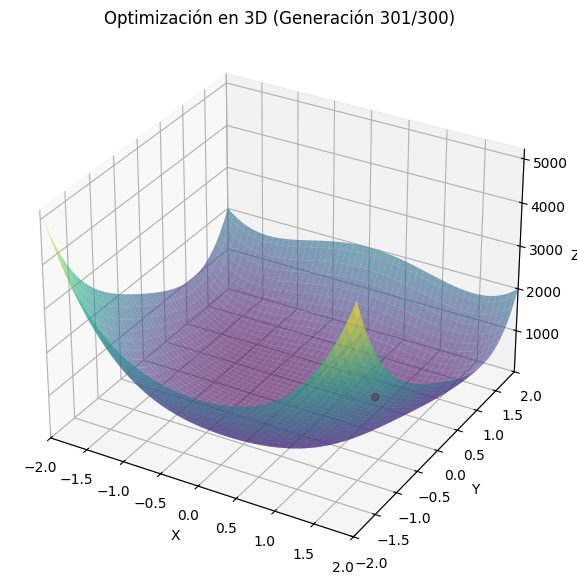

In [61]:
create_optimization_gif_3d(
    func=rosenbrock_3d,
    bounds=[(-2, 2), (-2, 2), (-2, 2)],
    population_history=population_history,
    generations=300,
    gif_name="rosenbrock_evolutionary_algorithm_3d.gif"
)

### Optimización Enjambre de Partículas

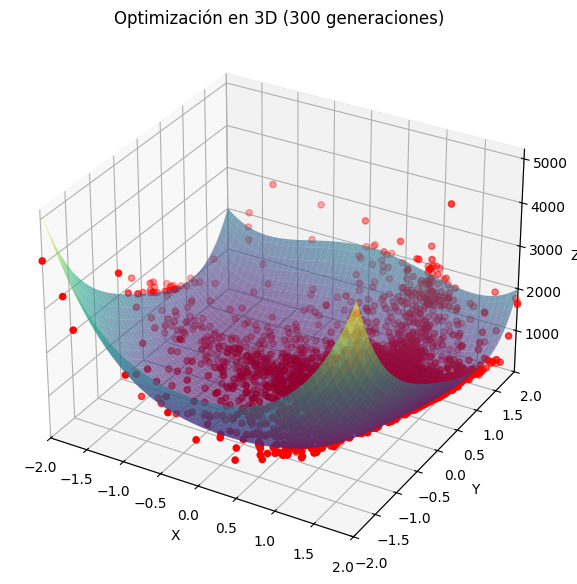

Mejor posición encontrada: [0.97540217 0.95110049 0.90403003]
Valor de la función objetivo: 0.003037354097867346


In [62]:
best_position, best_score, best_values, particle_history = particle_swarm_optimization_3d(
    func=rosenbrock_3d,
    bounds=[(-2, 2), (-2, 2), (-2, 2)],
    num_particles=50,
    generations=300,
    w=0.5,  # Factor de inercia
    c1=2.0,  # Factor cognitivo
    c2=2.0,  # Factor social
)

visualize_population_3d(
    func=rosenbrock_3d,
    bounds=[(-2, 2), (-2, 2), (-2, 2)],
    population_history=particle_history,
    generations=300,
)

print("Mejor posición encontrada:", best_position)
print("Valor de la función objetivo:", best_score)

C:\Users\alexg\AppData\Local\Temp\ipykernel_26504\1495813386.py:45: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  writer.append_data(imageio.imread(frame))


GIF guardado como: rosenbrock_pso_3d.gif


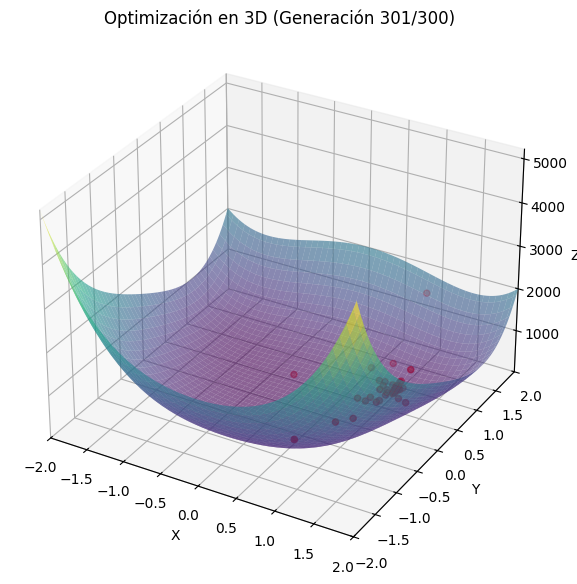

In [63]:
create_optimization_gif_3d(
    func=rosenbrock_3d,
    bounds=[(-2, 2), (-2, 2), (-2, 2)],
    population_history=particle_history,
    generations=300,
    gif_name="rosenbrock_pso_3d.gif"
)

### Evolución Diferencial

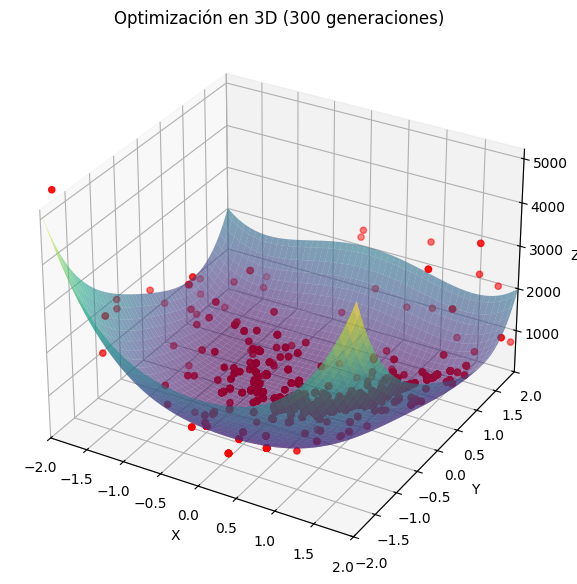

Mejor posición encontrada: [0.99999609 0.99999149 0.99998157]
Valor de la función objetivo: 3.3507199501026196e-10


In [64]:
best_position, best_score, best_values, population_history = differential_evolution_3d(
    func=rosenbrock_3d,
    bounds=[(-2, 2), (-2, 2), (-2, 2)],
    population_size=50,
    generations=300,
    mutation_factor=0.8,
    crossover_probability=0.7,
)

visualize_population_3d(
    func=rosenbrock_3d,
    bounds=[(-2, 2), (-2, 2), (-2, 2)],
    population_history=population_history,
    generations=300,
)


print("Mejor posición encontrada:", best_position)
print("Valor de la función objetivo:", best_score)

C:\Users\alexg\AppData\Local\Temp\ipykernel_26504\1495813386.py:45: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  writer.append_data(imageio.imread(frame))


GIF guardado como: rosenbrock_differential_evolution_3d.gif


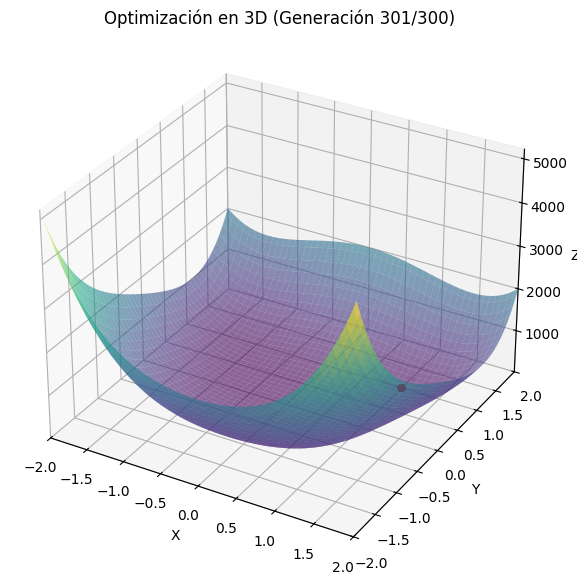

In [65]:
create_optimization_gif_3d(
    func=rosenbrock_3d,
    bounds=[(-2, 2), (-2, 2), (-2, 2)],
    population_history=population_history,
    generations=300,
    gif_name="rosenbrock_differential_evolution_3d.gif"
)

## Rastrigin

### Algoritmos Evolutivos

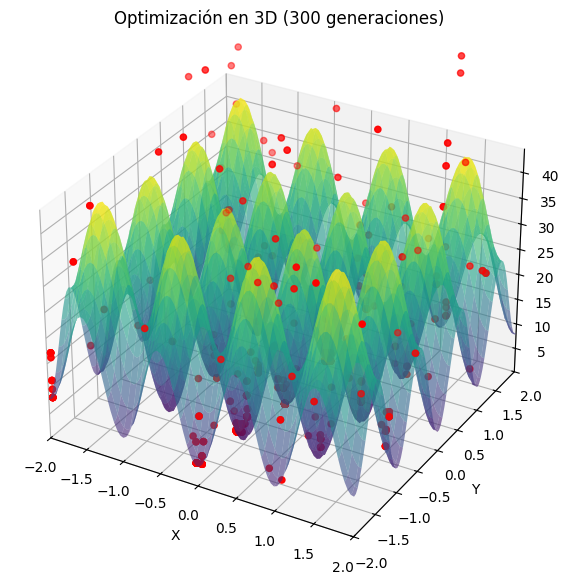

Mejor posición encontrada: [-2.37981631e-02 -6.08009240e-03 -1.48357459e-06]
Valor de la función objetivo: 0.11948490432776104


In [66]:
best_position, best_score, best_values, population_history = evolutionary_algorithm_3d(
    func=rastrigin_3d,
    bounds=[(-2, 2), (-2, 2), (-2, 2)],
    population_size=50,
    generations=300,
    mutation_rate=0.2,
    crossover_rate=0.5,
)

visualize_population_3d(
    func=rastrigin_3d,
    bounds=[(-2, 2), (-2, 2), (-2, 2)],
    population_history=population_history,
    generations=300,
)

print("Mejor posición encontrada:", best_position)
print("Valor de la función objetivo:", best_score)

In [ ]:
create_optimization_gif_3d(
    func=rastrigin_3d,
    bounds=[(-2, 2), (-2, 2), (-2, 2)],
    population_history=population_history,
    generations=300,
    gif_name="rastrigin_evolutionary_algorithm_3d.gif"
)

C:\Users\alexg\AppData\Local\Temp\ipykernel_26504\1495813386.py:45: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  writer.append_data(imageio.imread(frame))


### Optimización Enjambre de Partículas

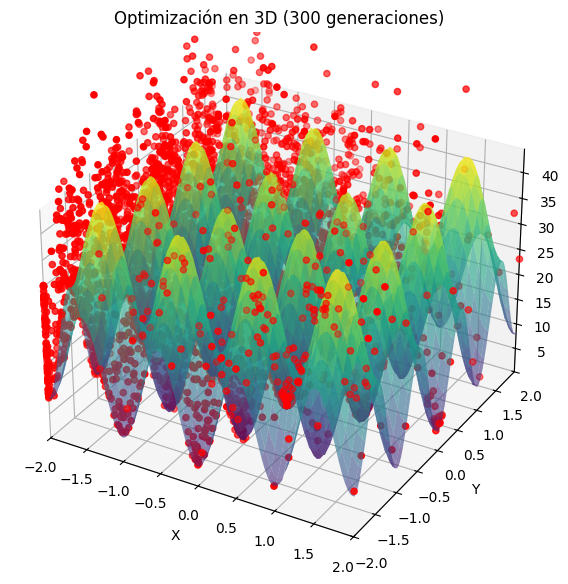

Mejor posición encontrada: [ 3.11293007e-09  9.24800289e-10 -5.75942952e-10]
Valor de la función objetivo: 0.0


In [ ]:
best_position, best_score, best_values, particle_history = particle_swarm_optimization_3d(
    func=rastrigin_3d,
    bounds=[(-2, 2), (-2, 2), (-2, 2)],
    num_particles=50,
    generations=300,
    w=0.5,  # Factor de inercia
    c1=2.0,  # Factor cognitivo
    c2=2.0,  # Factor social
)

visualize_population_3d(
    func=rastrigin_3d,
    bounds=[(-2, 2), (-2, 2), (-2, 2)],
    population_history=particle_history,
    generations=300,
)

print("Mejor posición encontrada:", best_position)
print("Valor de la función objetivo:", best_score)

C:\Users\alexg\AppData\Local\Temp\ipykernel_2652\1495813386.py:45: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  writer.append_data(imageio.imread(frame))


GIF guardado como: rastrigin_pso_3d.gif


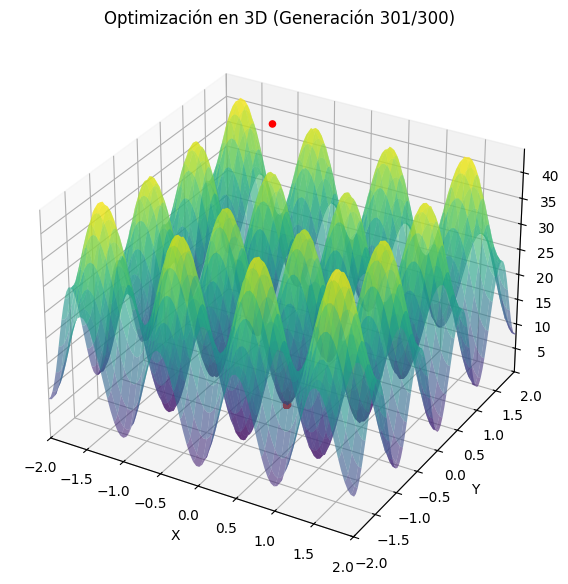

In [ ]:
create_optimization_gif_3d(
    func=rastrigin_3d,
    bounds=[(-2, 2), (-2, 2), (-2, 2)],
    population_history=particle_history,
    generations=300,
    gif_name="rastrigin_pso_3d.gif"
)

### Evolución Diferencial

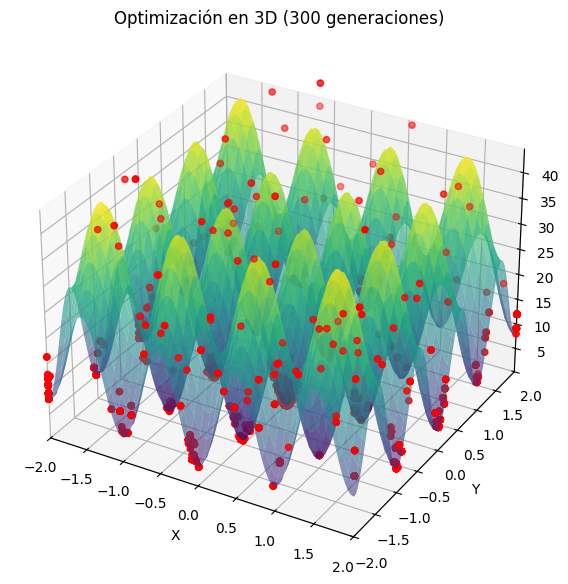

Mejor posición encontrada: [-9.80010087e-10 -7.89479712e-12 -4.41802109e-10]
Valor de la función objetivo: 0.0


In [ ]:
best_position, best_score, best_values, population_history = differential_evolution_3d(
    func=rastrigin_3d,
    bounds=[(-2, 2), (-2, 2), (-2, 2)],
    population_size=50,
    generations=300,
    mutation_factor=0.8,
    crossover_probability=0.7,
)

visualize_population_3d(
    func=rastrigin_3d,
    bounds=[(-2, 2), (-2, 2), (-2, 2)],
    population_history=population_history,
    generations=300,
)


print("Mejor posición encontrada:", best_position)
print("Valor de la función objetivo:", best_score)

C:\Users\alexg\AppData\Local\Temp\ipykernel_2652\1495813386.py:45: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  writer.append_data(imageio.imread(frame))


GIF guardado como: rastrigin_differential_evolution_3d.gif


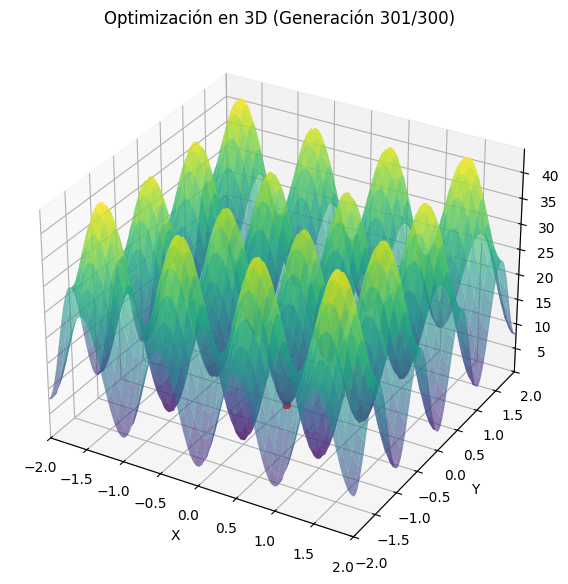

In [ ]:
create_optimization_gif_3d(
    func=rastrigin_3d,
    bounds=[(-2, 2), (-2, 2), (-2, 2)],
    population_history=population_history,
    generations=300,
    gif_name="rastrigin_differential_evolution_3d.gif"
)